In [7]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [10]:
# Read the training and test data sets
train_df = pd.read_csv('data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv', index_col='session_id')

# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [11]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open('data/site_dic.pkl', 'rb') as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print('Websites total: ', sites_dict.shape[0])
sites_dict.head()

Websites total:  48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [12]:
# Answer
print(test_df.shape, train_df.shape)

(82797, 20) (253561, 21)


In [15]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [16]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [189]:
corpus = full_df[sites].apply(lambda row: ' '.join([str(site) for site in row.values if site!=0]), axis=1).values

In [268]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.5, ngram_range=(1, 7))
tfidf_sparse = tfidf.fit_transform(corpus)

In [269]:
tfidf_sparse.shape

(336358, 5662762)

In [17]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

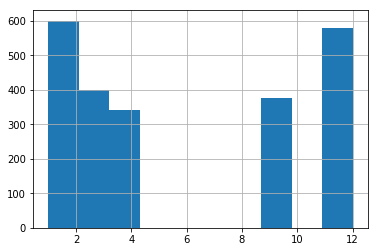

In [247]:
train_df[train_df.target > 0].time1.apply(lambda x: x.month).hist()

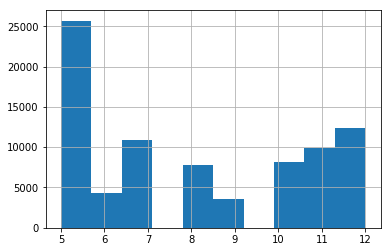

In [245]:
test_df.time1.apply(lambda x: x.month).hist()

In [320]:
def get_durations(timelist):
    a = [t for t in timelist if t != np.datetime64('NaT') ]
    if len(a) > 1:
        mean_dur = float(np.mean(np.diff(a)/1e9))
        total_dur = float(a[-1] - a[0])/1e9
    else:
        mean_dur, total_dur = 0.0, 0.0
    return pd.Series(np.log1p([mean_dur, total_dur]))    
    
time_feat_durations = full_df[times].apply(lambda row: get_durations(row.values), axis=1)

In [321]:
time_feat_durations.head(10)

,0,1
session_id,,
21669,0.000000,0.000000
54843,6.390241,7.488294
77292,0.000000,1.609438
114021,0.000000,1.386294
146670,0.000000,1.098612
242171,0.000000,1.386294
57157,0.000000,1.386294
240201,0.000000,1.386294
210686,0.000000,1.791759


In [295]:
times = ['time%s' % i for i in range(1, 11)]
time_feats = pd.DataFrame()
time_feats['hour'] = full_df['time1'].apply(lambda x: x.hour )
time_feats['hour_12_13'] = (time_feats.hour == 12) | (time_feats.hour == 13)
time_feats['hour_12_13'] = time_feats['hour_12_13'].astype(int)
time_feats['hour_16_18'] = (time_feats.hour >= 16) & (time_feats.hour <=18)
time_feats['hour_16_18'] = time_feats['hour_16_18'].astype(int)
time_feats['weekday'] = full_df['time1'].apply(lambda x: x.weekday())
time_feats['month'] = full_df['time1'].apply(lambda x: x.month)
time_feats.shape

(336358, 5)

In [249]:
time_feats.head()

,hour,hour_12_13,hour_16_18,weekday,month
session_id,,,,,
21669,8,0,0,5,1
54843,8,0,0,5,1
77292,8,0,0,5,1
114021,8,0,0,5,1
146670,8,0,0,5,1


In [322]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
time_sparse = hstack((ohe.fit_transform(time_feats), time_feat_durations)).tocsr()

In [323]:
full_sparse = hstack((tfidf_sparse, time_sparse)).tocsr()
full_sparse.shape, type(full_sparse)

((336358, 5662804), scipy.sparse.csr.csr_matrix)

In [324]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.8, class_weight='balanced'):
    # Split the data into the ta\raining and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1, class_weight=class_weight).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [325]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train, ratio=0.8))

0.952863740338
CPU times: user 2min 50s, sys: 2.79 s, total: 2min 53s
Wall time: 43.6 s


In [259]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(random_state=17, n_jobs=-1)
param_grid = {'C': [10**i for i in range(-5, 5)]}
gs = GridSearchCV(lr, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
#gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [264]:
gs.best_score_, gs.best_params_
print(get_auc_lr_valid(X_train, y_train, ratio=0.8))

0.958156281331


In [204]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [303]:
full_sparse.shape

(336358, 5662804)

In [327]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, class_weight='balanced').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'tfidf13_hour12_18_dur_log.csv')